In [1]:
import h5py
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import sys
sys.path.append('../../number_recognition/inpaintingNumbers')
from featExtr import normalizedArea, normalizedRect, normalizedCentroid, getNormPerimeter
import random

In [2]:
fname = '/home/nina/Documents/hockey_tracking/number_recognition/SynthText/data/dsetInpaint.h5'
outDir = '../data/test_seg/'

In [35]:
"""
f = h5py.File(fname)
segGr = f['seg']
imNames = segGr.keys()
for imName in imNames:
    seg = segGr[imName]
    seg = np.array(seg)
    max_n = seg.max()
    seg = np.array(seg / max_n * 254, dtype=np.uint8)
    cv2.imwrite(os.path.join(outDir, imName), seg)
"""

In [3]:
allImgPaths = [os.path.join(outDir, f) for f in os.listdir(outDir)]
allImgPaths = filter(os.path.isfile, allImgPaths)
allImgs = [cv2.imread(path)[:,:,0] for path in allImgPaths]

In [4]:
trainImgPaths = [os.path.join(outDir, '{}.png'.format(i)) for i in range(40)]
trainImgs = [cv2.imread(path)[:,:,0] for path in trainImgPaths]
def getTrueSeg(img):
    whitePixelMask = img == 255
    coords = np.argwhere(whitePixelMask)
    if len(coords) == 0:
        return None
    r, c = coords[0]
    mark = img[r - 1, c]
    img[r, c] = mark
    return np.array(img == mark, np.uint8)

trainSegs = [getTrueSeg(img) for img in trainImgs]
trainSegs = list(filter(lambda x: x is not None, trainSegs))

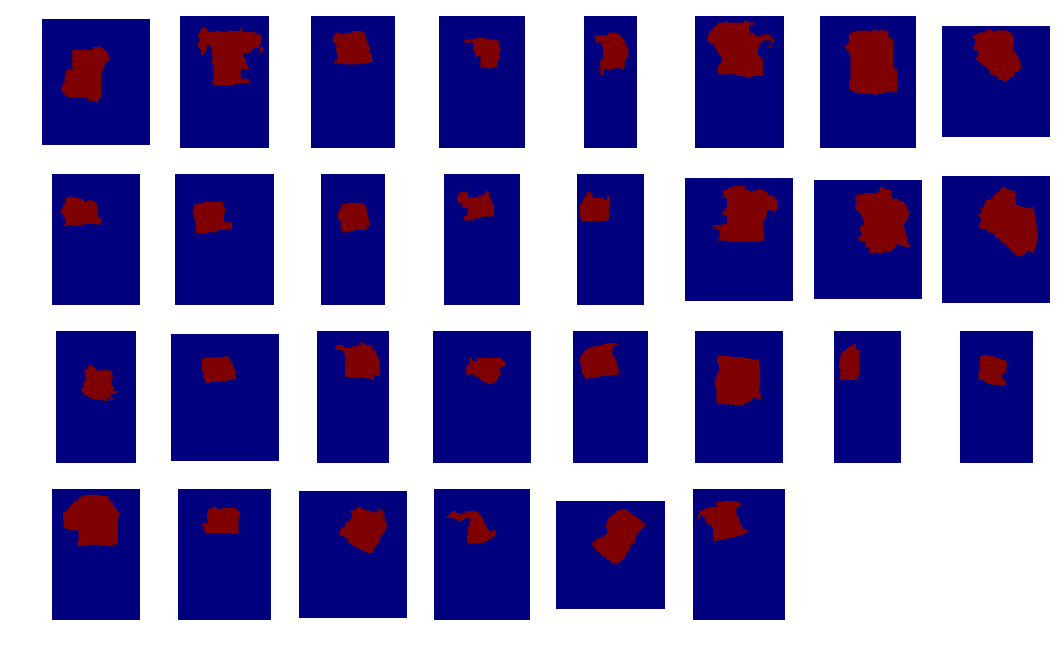

In [251]:
N = 80
plt.figure(figsize=(13, 20))
n = 0
for seg in trainSegs:
    if n >= N: break
    plt.subplot(10, 8, n + 1), plt.axis('off')#, plt.title(len(numberMasks))
    plt.imshow(seg)        
    n += 1
plt.show()

In [320]:
def getRectParam(mask):
    x,y,w,h = cv2.boundingRect(mask)
    return x,y,x+w, y+h, w,h
def normalizedRectParam(mask):
    x1,y1,x2,y2,w,h = getRectParam(mask)
    full_h, full_w = mask.shape
    x1 = x1 / full_w
    y1 = y1 / full_h
    x2 = x2 / full_w
    y2 = y2 / full_h
    w = w / full_w
    h = h / full_h
    return x1, y1, w, h #x1, y1, x2, y2, w, h, w/h

def createFeatures(inX):
    fs = []
    fs.append(normalizedArea(inX))
    fs.extend(normalizedRectParam(inX))
    fs.extend(normalizedCentroid(inX))
    fs.append(getNormPerimeter(inX))
    return fs

def extractFeatures(inX):
    assert len(inX) != 0
    X = np.empty((len(inX), len(createFeatures(inX[0]))))
    for i, obj in enumerate(inX):
        X[i, :] = createFeatures(obj)
    return X

X_train = extractFeatures(trainSegs)

In [321]:
np.set_printoptions(3)
for i, x in enumerate(X_train):
    print(i, x)

0 [ 0.13   0.18   0.215  0.439  0.46   0.402  0.44   0.805]
1 [ 0.192  0.206  0.1    0.745  0.431  0.546  0.289  1.324]
2 [ 0.095  0.264  0.121  0.472  0.257  0.49   0.25   0.676]
3 [ 0.059  0.295  0.164  0.42   0.237  0.55   0.273  0.587]
4 [ 0.127  0.21   0.123  0.63   0.33   0.537  0.274  0.796]
5 [ 0.201  0.143  0.045  0.733  0.427  0.48   0.252  1.156]
6 [ 0.218  0.225  0.106  0.581  0.497  0.537  0.357  0.997]
7 [ 0.137  0.29   0.04   0.447  0.467  0.513  0.251  0.848]
8 [ 0.076  0.095  0.179  0.46   0.227  0.317  0.294  0.625]
9 [ 0.072  0.178  0.221  0.395  0.237  0.353  0.337  0.578]
10 [ 0.09   0.267  0.225  0.505  0.225  0.504  0.332  0.574]
11 [ 0.07   0.176  0.139  0.477  0.221  0.427  0.248  0.662]
12 [ 0.079  0.044  0.138  0.469  0.227  0.262  0.268  0.601]
13 [ 0.178  0.254  0.074  0.605  0.448  0.559  0.301  1.082]
14 [ 0.2    0.383  0.067  0.503  0.552  0.63   0.347  1.076]
15 [ 0.183  0.33   0.096  0.557  0.534  0.63   0.367  1.005]
16 [ 0.078  0.317  0.266  0.441  0

In [322]:
meanX = np.mean(X_train, axis=0)
stdX = np.std(X_train, axis=0)
minX = meanX - 3 * stdX
maxX = meanX + 3 * stdX
eps = 0.001

#minX = np.where(minX > 0, minX, np.full(minX.shape, eps))
#maxX[:-1] = np.where(maxX[:-1] < 1, maxX[:-1], np.full(maxX[:-1].shape, 1 - eps))
print(minX)
print(maxX)

[-0.04  -0.06  -0.039  0.189 -0.002  0.164  0.14   0.147]
[ 0.271  0.502  0.31   0.813  0.661  0.783  0.455  1.389]


In [325]:
def getSegMasks(seg):
    labels = np.unique(seg)
    masks = []
    for l in labels:
        masks.append(np.array(seg == l, dtype=np.uint8))
    return masks

def findTrueSeg(seg):
    masks = getSegMasks(seg)
    X = extractFeatures(masks)
    filt = np.logical_and(np.all(X > minX, axis =1), np.all(X < maxX, axis=1))
    trueMask = []
    for i in np.where(filt)[0]:
        trueMask.append(masks[i])    
    return trueMask

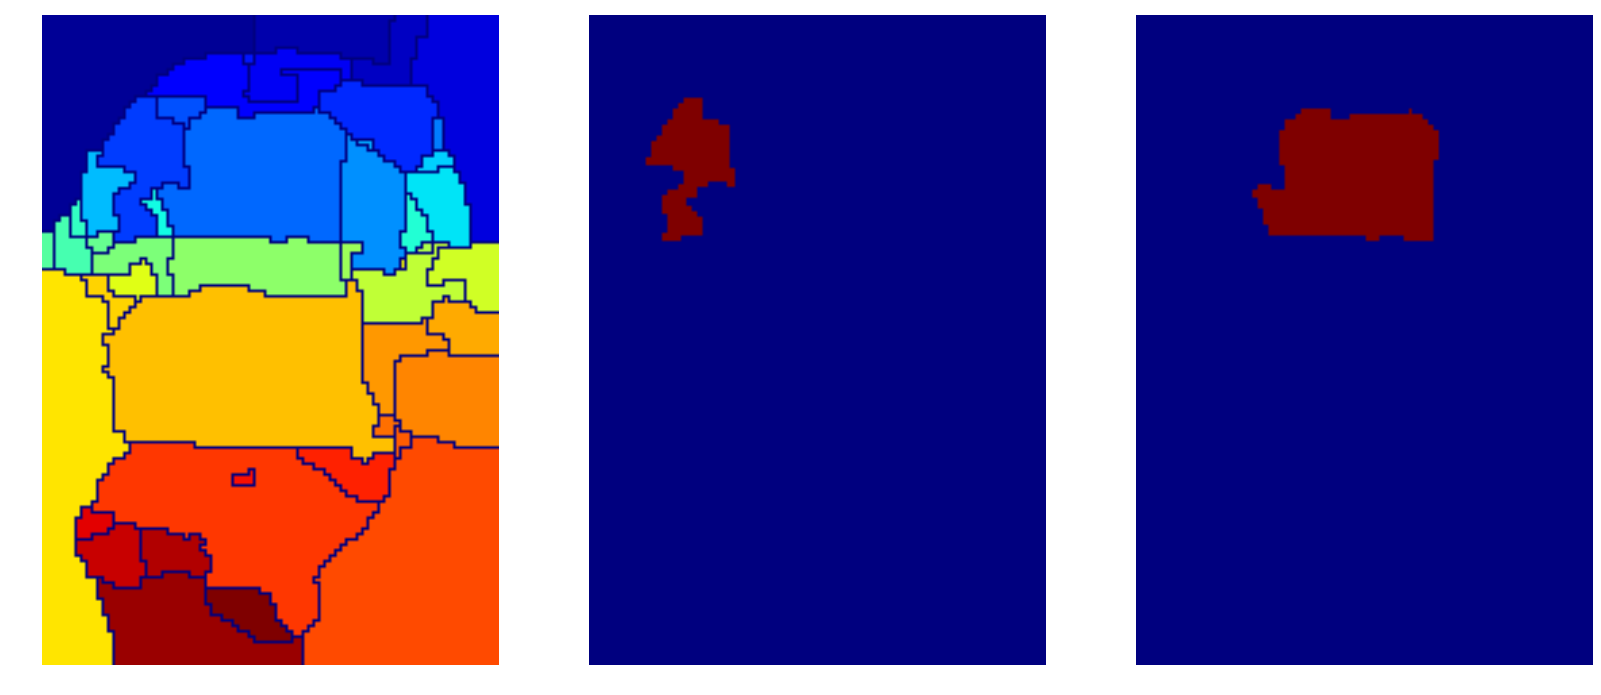

In [326]:
curImg = testImgs[1]
trueMask = findTrueSeg(curImg)
c = len(trueMask) + 1
plt.figure(figsize=(20, 10))
plt.subplot(1, c, 1), plt.imshow(curImg), plt.axis('off')
for i, curMask in enumerate(trueMask):
    plt.subplot(1, c, i + 2), plt.imshow(curMask), plt.axis('off')
plt.show()

In [327]:
testImgs = allImgs[:]
random.shuffle(testImgs)

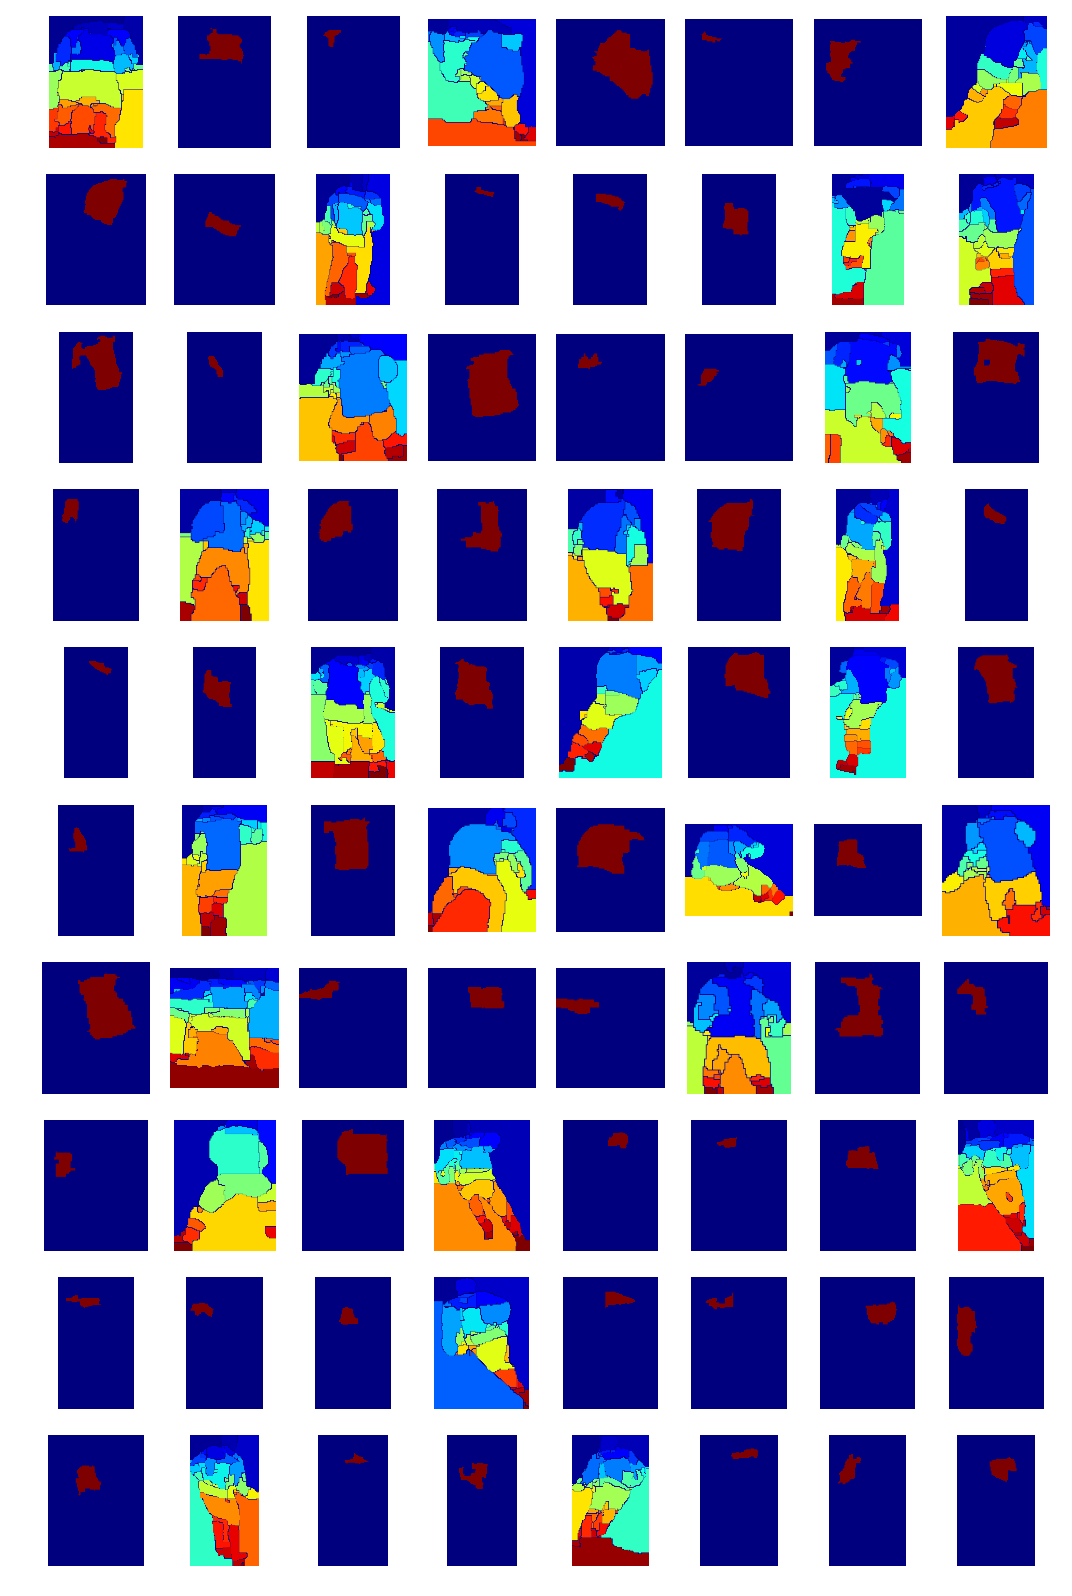

In [328]:
N = 80
plt.figure(figsize=(13, 20))
n = 0
for curImg in testImgs:
    plt.subplot(10, 8, n + 1), plt.axis('off')
    plt.imshow(curImg)  
    n += 1
    trueMask = findTrueSeg(curImg)
    for curMask in trueMask:
        plt.subplot(10, 8, n + 1), plt.axis('off')
        plt.imshow(curMask)
        n += 1
        if n >= N: break
    if n + 1 >= N: break
plt.show()

In [23]:
ys, xs = np.where(seg)
x, y = np.min(xs), np.min(ys)
w, h = np.unique(xs).shape[0], np.unique(ys).shape[0]